In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras  import callbacks
from keras import optimizers
import pandas as pd 
import tensorflow as tf
import numpy as np

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv('/Users/pradeep/exp/capstone/data/Fine_2014_2019_Finger_millet_Min_Blore_Mysore.csv')
df1.head()

,district,commodity,Arrival Date,variety,Min_price
0,Mysore,Ragi (Finger Millet),02-01-14,Fine,1600
1,Mysore,Ragi (Finger Millet),03-01-14,Fine,2000
2,Mysore,Ragi (Finger Millet),04-01-14,Fine,1800
3,Mysore,Ragi (Finger Millet),07-01-14,Fine,2000
4,Mysore,Ragi (Finger Millet),08-01-14,Fine,2100


In [3]:
gp = pd.pivot_table(df1,values='Min_price',columns=['district','commodity'],index=['Arrival Date'])


In [4]:
flattened = pd.DataFrame(gp.to_records())
flattened['Arrival Date'] = pd.to_datetime(flattened['Arrival Date'])
flattened = flattened.sort_values(by=['Arrival Date'])
df = flattened.reset_index()
del df['index']

df = df.set_index('Arrival Date').asfreq('D')
df = df.fillna(method='ffill')
df.head()

,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
Arrival Date,,
2014-01-03,1800.0,1800.0
2014-01-04,1800.0,1800.0
2014-01-05,1800.0,1800.0
2014-01-06,1800.0,1800.0
2014-01-07,1700.0,1700.0


In [5]:
df.to_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv', encoding='utf-8')

In [6]:
df = pd.read_csv('/Users/pradeep/exp/capstone/data/Finger_millet_2006_2019_Complete_after_PreProcessing.csv')

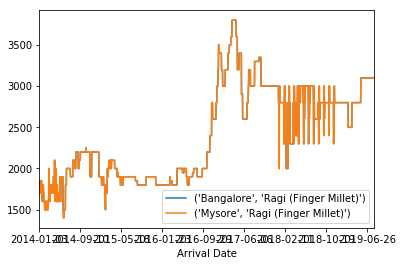

In [7]:
df.plot(x='Arrival Date')

In [8]:
df['Arrival Date'] = pd.to_datetime(df['Arrival Date']).astype('int')
df.describe()

,Arrival Date,"('Bangalore', 'Ragi (Finger Millet)')","('Mysore', 'Ragi (Finger Millet)')"
count,2.044000e+03,2044.00000,2044.00000
mean,1.476965e+18,2406.38454,2406.38454
std,5.099296e+16,566.48057,566.48057
min,1.388707e+18,1400.00000,1400.00000
25%,1.432836e+18,1900.00000,1900.00000
50%,1.476965e+18,2200.00000,2200.00000
75%,1.521094e+18,3000.00000,3000.00000
max,1.565222e+18,3800.00000,3800.00000


In [9]:
training_set = df.iloc[:,[1,2]].values
training_set

array([[1800., 1800.],
       [1800., 1800.],
       [1800., 1800.],
       ...,
       [3100., 3100.],
       [3100., 3100.],
       [3100., 3100.]])

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(training_set)

In [11]:
train_size = int(len(scaled) * 0.75)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 1533
test: 511


In [12]:
print(train.shape)
print(test.shape)

(1533, 2)
(511, 2)


In [13]:
train

array([[0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       [0.16666667, 0.16666667],
       ...,
       [0.375     , 0.375     ],
       [0.375     , 0.375     ],
       [0.375     , 0.375     ]])

In [14]:
def create_dataset(dataset, look_back=32):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        b = dataset[i + look_back]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1533 16
511 16


In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1516, 16, 2)
(494, 16, 2)
(1516, 2)
(494, 2)


In [17]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2] ))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print(X_train.shape)
print(X_test.shape)

(1516, 16, 2)
(494, 16, 2)


In [18]:
batch_size = 2
model = Sequential()
model.add(LSTM(units=400, batch_input_shape=(batch_size, look_back, 2), stateful=True))

model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

W0124 07:30:58.124150 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0124 07:30:58.144191 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0124 07:30:58.147663 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0124 07:30:58.516149 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (2, 400)                  644800    
_________________________________________________________________
dense_1 (Dense)              (2, 2)                    802       
Total params: 645,602
Trainable params: 645,602
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

W0124 07:30:58.676285 140735499449152 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0124 07:30:58.963818 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0124 07:30:59.036429 140735499449152 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
 - 13s - loss: 0.0043
Epoch 2/20
 - 13s - loss: 0.0018
Epoch 3/20
 - 14s - loss: 0.0014
Epoch 4/20
 - 14s - loss: 0.0013
Epoch 5/20
 - 14s - loss: 0.0013
Epoch 6/20
 - 14s - loss: 0.0014
Epoch 7/20
 - 14s - loss: 0.0012
Epoch 8/20
 - 14s - loss: 0.0013
Epoch 9/20
 - 14s - loss: 0.0014
Epoch 10/20
 - 14s - loss: 0.0012
Epoch 11/20
 - 14s - loss: 0.0011
Epoch 12/20
 - 14s - loss: 0.0011
Epoch 13/20
 - 14s - loss: 0.0012
Epoch 14/20
 - 14s - loss: 0.0012
Epoch 15/20
 - 14s - loss: 0.0012
Epoch 16/20
 - 14s - loss: 0.0012
Epoch 17/20
 - 14s - loss: 0.0011
Epoch 18/20
 - 14s - loss: 0.0012
Epoch 19/20
 - 14s - loss: 0.0012
Epoch 20/20
 - 15s - loss: 0.0012


In [20]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [21]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 930.20 MSE
Test Score column 0: 242371.13 MSE
Train Score column 1: 897.88 MSE
Test Score column 1: 401.68 MSE


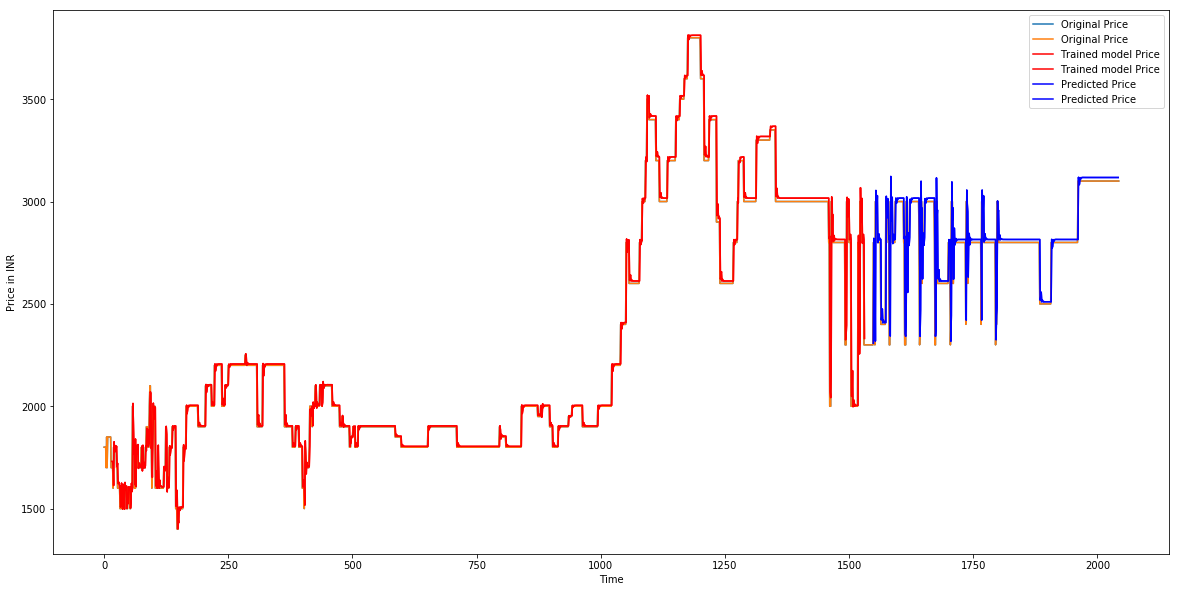

In [22]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Trained model Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()

In [39]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1533 16
511 16


In [40]:
## Stacked LSTM
#batch_size = 1
modelst = Sequential()
modelst.add(LSTM(units=200, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
#model.add(LSTM(50, return_sequences=True))  
modelst.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
modelst.add(LSTM(units=50, batch_input_shape=(batch_size, look_back, 2),return_sequences=True, stateful=True))
modelst.add(LSTM(units=200, batch_input_shape=(batch_size, look_back, 2), stateful=True))
modelst.add(Dense(2))
modelst.compile(loss='mean_squared_error', optimizer='adam')
modelst.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (1, 16, 200)              162400    
_________________________________________________________________
lstm_18 (LSTM)               (1, 16, 100)              120400    
_________________________________________________________________
lstm_19 (LSTM)               (1, 16, 50)               30200     
_________________________________________________________________
lstm_20 (LSTM)               (1, 200)                  200800    
_________________________________________________________________
dense_6 (Dense)              (1, 2)                    402       
Total params: 514,202
Trainable params: 514,202
Non-trainable params: 0
_________________________________________________________________


In [41]:
modelst.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 52s - loss: 0.0076
Epoch 2/20
 - 49s - loss: 0.0025
Epoch 3/20
 - 49s - loss: 0.0021
Epoch 4/20
 - 49s - loss: 0.0020
Epoch 5/20
 - 49s - loss: 0.0017
Epoch 6/20
 - 49s - loss: 0.0020
Epoch 7/20
 - 49s - loss: 0.0016
Epoch 8/20
 - 49s - loss: 0.0017
Epoch 9/20
 - 49s - loss: 0.0018
Epoch 10/20
 - 49s - loss: 0.0016
Epoch 11/20
 - 51s - loss: 0.0017
Epoch 12/20
 - 49s - loss: 0.0015
Epoch 13/20
 - 49s - loss: 0.0015
Epoch 14/20
 - 49s - loss: 0.0015
Epoch 15/20
 - 49s - loss: 0.0014
Epoch 16/20
 - 49s - loss: 0.0016
Epoch 17/20
 - 48s - loss: 0.0016
Epoch 18/20
 - 48s - loss: 0.0014
Epoch 19/20
 - 48s - loss: 0.0014
Epoch 20/20
 - 49s - loss: 0.0014


In [26]:
trainPredict = modelst.predict(X_train, batch_size=batch_size)
modelst.reset_states()

testPredict = modelst.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 937.84 MSE
Test Score column 0: 232383.98 MSE
Train Score column 1: 1952.27 MSE
Test Score column 1: 907.36 MSE


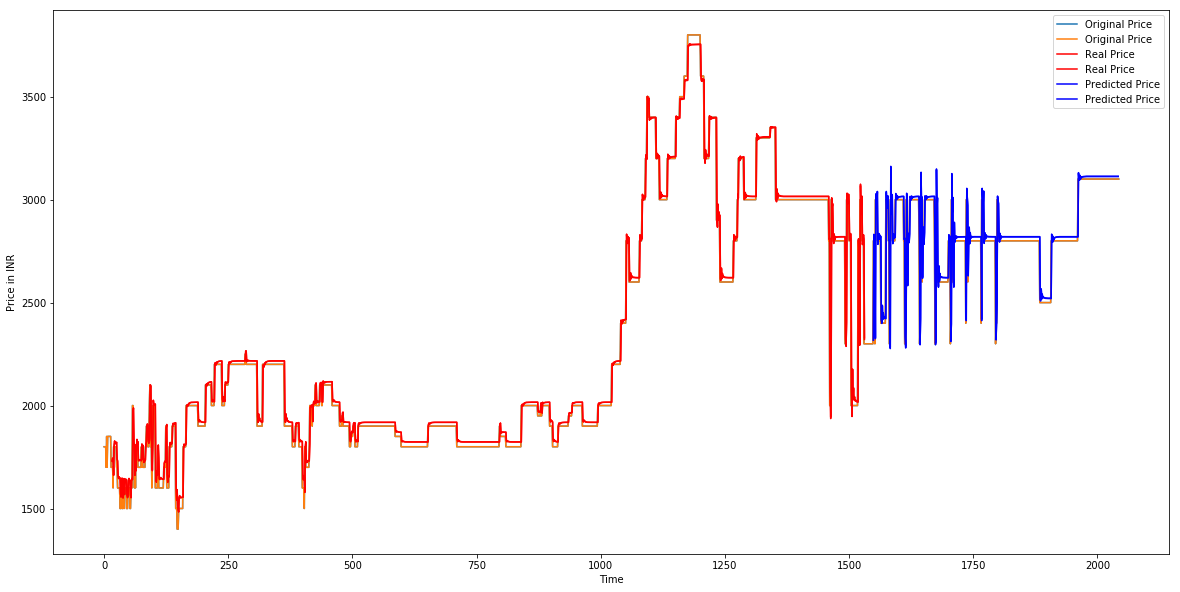

In [27]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Real Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()

In [28]:
look_back = 16
#32
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

1533 16
511 16


In [29]:
## GRU
batch_size = 1
modelg = Sequential()
modelg.add(GRU(units=200, batch_input_shape=(batch_size, look_back, 2), stateful=True))
#model.add(LSTM(50, return_sequences=True))  
#model.add(LSTM(units=100, batch_input_shape=(batch_size, look_back, 1), stateful=True))

modelg.add(Dense(2))
modelg.compile(loss='mean_squared_error', optimizer='adam')
modelg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (1, 200)                  121800    
_________________________________________________________________
dense_3 (Dense)              (1, 2)                    402       
Total params: 122,202
Trainable params: 122,202
Non-trainable params: 0
_________________________________________________________________


In [30]:
modelg.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/20
 - 13s - loss: 0.0021
Epoch 2/20
 - 12s - loss: 0.0014
Epoch 3/20
 - 12s - loss: 0.0013
Epoch 4/20
 - 12s - loss: 0.0014
Epoch 5/20
 - 12s - loss: 0.0013
Epoch 6/20
 - 12s - loss: 0.0013
Epoch 7/20
 - 12s - loss: 0.0012
Epoch 8/20
 - 12s - loss: 0.0012
Epoch 9/20
 - 12s - loss: 0.0012
Epoch 10/20
 - 12s - loss: 0.0012
Epoch 11/20
 - 12s - loss: 0.0011
Epoch 12/20
 - 12s - loss: 0.0012
Epoch 13/20
 - 12s - loss: 0.0012
Epoch 14/20
 - 12s - loss: 0.0012
Epoch 15/20
 - 12s - loss: 0.0012
Epoch 16/20
 - 12s - loss: 0.0012
Epoch 17/20
 - 12s - loss: 0.0011
Epoch 18/20
 - 12s - loss: 0.0011
Epoch 19/20
 - 12s - loss: 0.0011
Epoch 20/20
 - 12s - loss: 0.0011


In [31]:
trainPredict = modelg.predict(X_train, batch_size=batch_size)
modelg.reset_states()

testPredict = modelg.predict(X_test, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)
# calculate root mean squared error
trainScore = mean_squared_error(y_train[0], trainPredict[0])
print('Train Score column 0: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[0], testPredict[0])
print('Test Score column 0: %.2f MSE' % (testScore))
trainScore = mean_squared_error(y_train[1], trainPredict[1])
print('Train Score column 1: %.2f MSE' % (trainScore))
testScore = mean_squared_error(y_test[1], testPredict[1])
print('Test Score column 1: %.2f MSE' % (testScore))

Train Score column 0: 617.06 MSE
Test Score column 0: 249164.52 MSE
Train Score column 1: 482.64 MSE
Test Score column 1: 1410.48 MSE


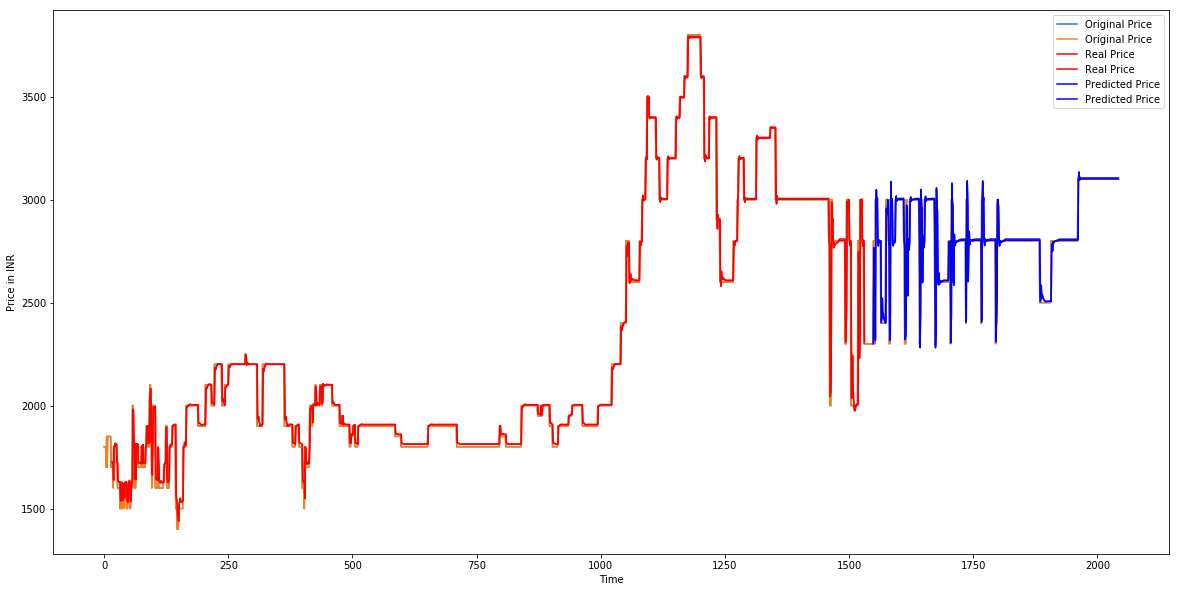

In [32]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled),label = 'Original Price')
plt.plot(trainPredictPlot, color = 'red', label = 'Real Price')
plt.plot(testPredictPlot, color = 'blue', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price in INR')
plt.legend()
#plt.plot(x='Arrival Date')
plt.show()